Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk

all_stream_data = load_from_disk("data/processed/all_stream_data")


In [2]:
print(all_stream_data)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 72342
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1925
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1926
    })
})


In [3]:
from transformers import AutoTokenizer
import torch

model_id = "allenai/scibert_scivocab_uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)


In [4]:
train_dataset = all_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = all_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


In [5]:
labels = all_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [6]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# from huggingface_hub import notebook_login
# notebook_login()


In [8]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 32
num_train_epochs = 4
learning_rate = 2e-5
logging_steps = len(train_dataset) // batch_size
model_name = f"./models/scibert-finetuned-arxiv-test"
training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size * 2,
                                  weight_decay=0.01,
                                  warmup_steps=300,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=300,
                                  save_steps=300,
                                  save_strategy="steps",
                                  save_total_limit=3,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=False,
                                  label_smoothing_factor=0.1,
                                  log_level="error")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [10]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
300,No log,1.082244,0.563650,0.680549
600,No log,0.801727,0.605962,0.723664
900,No log,0.625092,0.642022,0.809570
1200,No log,0.644512,0.666395,0.810764
1500,No log,0.549865,0.691277,0.835851
1800,No log,0.535642,0.729846,0.819242
2100,No log,0.558684,0.717469,0.835587
2400,0.933600,0.559438,0.736170,0.815861
2700,0.933600,0.626567,0.707300,0.811633
3000,0.933600,0.599953,0.709354,0.800912


TrainOutput(global_step=7200, training_loss=0.5531013785468207, metrics={'train_runtime': 2005.6814, 'train_samples_per_second': 144.274, 'train_steps_per_second': 4.509, 'total_flos': 3.031025644265472e+16, 'train_loss': 0.5531013785468207, 'epoch': 3.184431667403804})

In [11]:
preds_output = trainer.predict(eval_dataset)


In [12]:
preds_output.metrics


{'test_loss': 0.5197176933288574,
 'test_macro_f1': 0.7885923855432242,
 'test_balanced_accuracy': 0.876970675754414,
 'test_runtime': 4.5912,
 'test_samples_per_second': 419.278,
 'test_steps_per_second': 6.752}

In [13]:
y_preds = np.argmax(preds_output.predictions, axis=1)


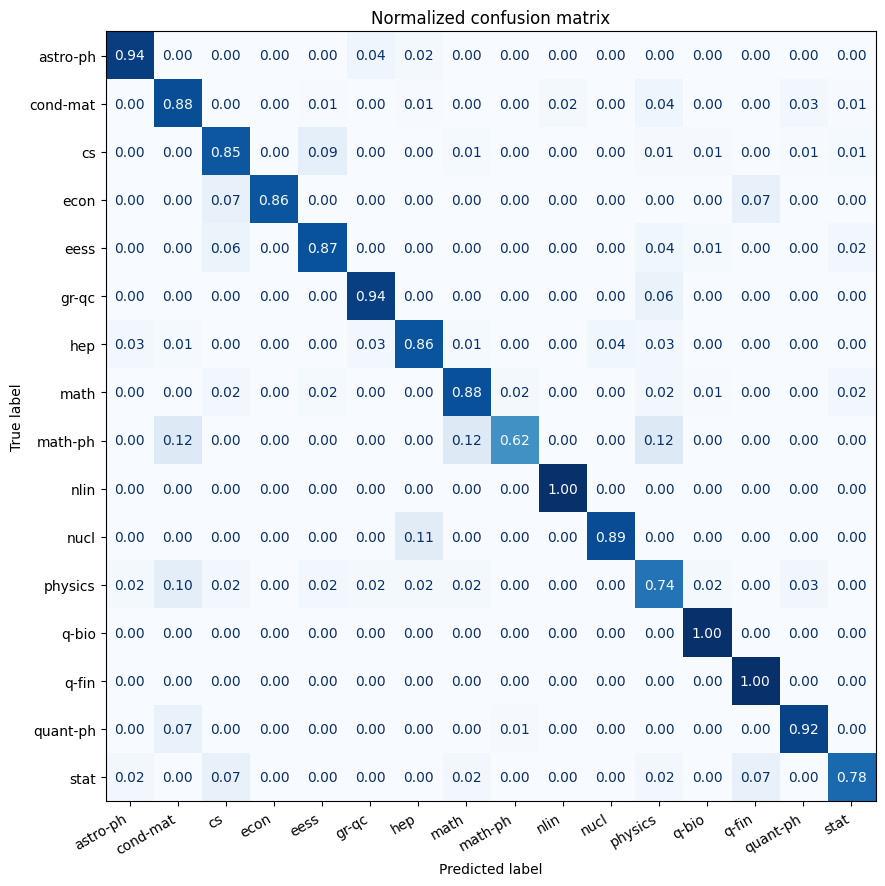

In [14]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.96      0.94      0.95       120
    cond-mat       0.85      0.88      0.86       137
          cs       0.97      0.85      0.91       818
        econ       1.00      0.86      0.92        14
        eess       0.46      0.87      0.61        84
       gr-qc       0.75      0.94      0.83        32
         hep       0.91      0.86      0.88        79
        math       0.95      0.88      0.91       331
     math-ph       0.42      0.62      0.50         8
        nlin       0.53      1.00      0.70         8
        nucl       0.84      0.89      0.86        18
     physics       0.75      0.74      0.74       123
       q-bio       0.54      1.00      0.70        15
       q-fin       0.50      1.00      0.67         7
    quant-ph       0.86      0.92      0.89        90
        stat       0.60      0.78      0.68        41

    accuracy                           0.86      1925
   macro avg       0.74   

In [16]:
test_dataset = all_stream_data["test"].map(
    tokenize, batched=True, batch_size=None
)


In [17]:
preds_output = trainer.predict(test_dataset)
preds_output.metrics


{'test_loss': 0.8245481848716736,
 'test_macro_f1': 0.7257049492133707,
 'test_balanced_accuracy': 0.7932216539886019,
 'test_runtime': 4.5859,
 'test_samples_per_second': 419.985,
 'test_steps_per_second': 6.76}

In [18]:
y_test = np.array(test_dataset["label"])


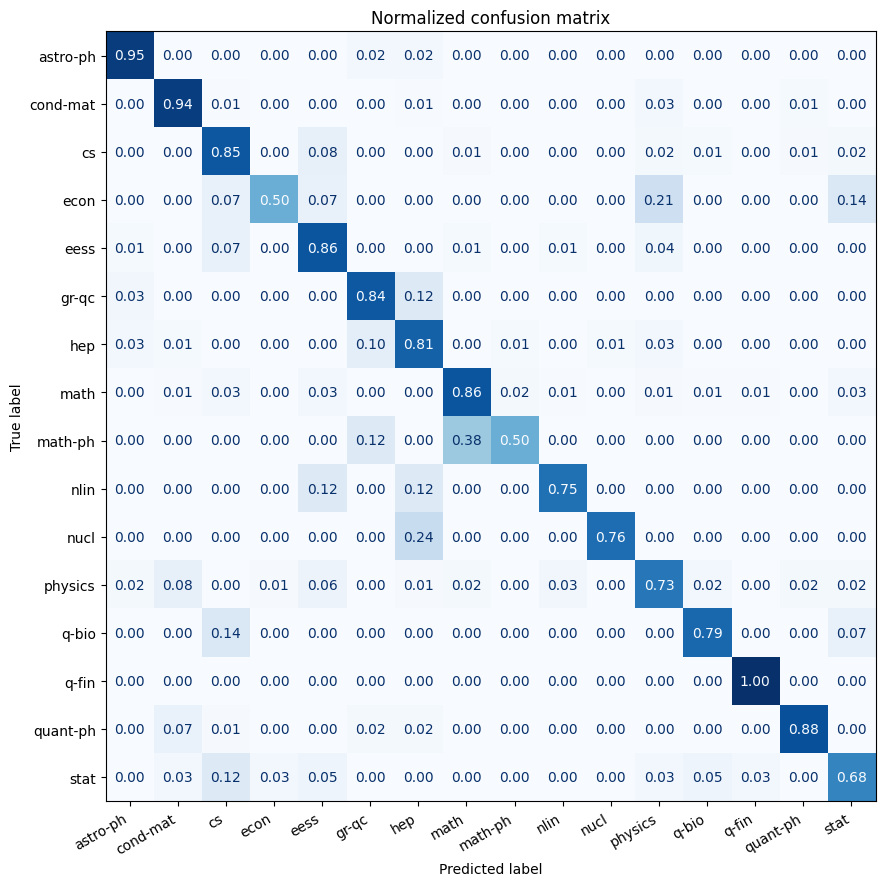

              precision    recall  f1-score   support

    astro-ph       0.94      0.95      0.95       121
    cond-mat       0.87      0.94      0.90       137
          cs       0.97      0.85      0.90       819
        econ       0.70      0.50      0.58        14
        eess       0.46      0.86      0.60        85
       gr-qc       0.66      0.84      0.74        32
         hep       0.80      0.81      0.81        79
        math       0.96      0.86      0.90       331
     math-ph       0.33      0.50      0.40         8
        nlin       0.46      0.75      0.57         8
        nucl       0.93      0.76      0.84        17
     physics       0.74      0.73      0.73       124
       q-bio       0.37      0.79      0.50        14
       q-fin       0.58      1.00      0.74         7
    quant-ph       0.88      0.88      0.88        90
        stat       0.49      0.68      0.57        40

    accuracy                           0.85      1926
   macro avg       0.70   

In [19]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_test, labels)
print(classification_report(y_test, y_preds, target_names=labels))
